In [1]:
import deepxde as dde
import numpy as np
dde.backend.set_default_backend("pytorch")
import matplotlib.pyplot as plt
import torch
import math

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [2]:
def solution(x,t,L,n_max):
    V = t/L + L/3
    for n in range(1,n_max+1):
        V+=-2*L/(math.pi**2*n**2)*torch.exp(-math.pi**2*n**2*t/L**2)*torch.cos(math.pi*n*x/L)
    return -2 + 2*torch.sqrt(-x + x**2/(2*L) + 1 + V)

In [3]:
L = 1.0  # длина стержня
T = 1.0 

geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)



#TODO учет сложных точек там какая то херь была


In [19]:
import deepxde as dde
import numpy as np



def pde(x, u):
    du_t = dde.grad.jacobian(u, x, i=0, j=1)  # производная по времени
    du_xx = dde.grad.hessian(u, x, i=0, j=0)  # вторая производная по x
    return du_t - 1/(1+u) * du_xx
def boundary_left(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0) and not np.isclose(x[1],0)
def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], L) and not np.isclose(x[1],0)
bc_left = dde.NeumannBC(geomtime, lambda x: 0, boundary_right)
bc_right = dde.NeumannBC(geomtime, lambda x: 1, boundary_left)
ic = dde.IC(
    geomtime,
    lambda x: 0,
    lambda _, on_initial: on_initial,
)
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, T)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Сборка задачи
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_left, bc_right, ic],
    num_domain=3000,  # точек внутри области
    num_boundary=500, # точек на границе
    num_initial=500,  # точек для начального условия
)
net = dde.nn.FNN(
    [2] + [100] * 2 + [1],  # 2 входа (x,t), 4 слоя по 32 нейрона, 1 выход
    "tanh",
    "Glorot normal",
)
# Модель и обучение
model = dde.Model(data, net)



In [20]:
resampler = dde.callbacks.PDEPointResampler(period=100)  # Пересчет точек каждые 100 эпох


model.compile("adam", lr=1e-3)
model.train(iterations=15000,callbacks=[resampler])
model.compile('L-BFGS')
losshistory, train_state = model.train()


Compiling model...
'compile' took 0.000985 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.73e-02, 1.45e-03, 1.04e+00, 2.24e-04]    [3.73e-02, 1.45e-03, 1.04e+00, 2.24e-04]    []  
1000      [9.72e-04, 1.42e-03, 1.10e-03, 8.17e-03]    [9.60e-04, 1.42e-03, 1.10e-03, 8.17e-03]    []  
2000      [1.23e-03, 7.62e-04, 1.13e-03, 3.10e-03]    [1.21e-03, 7.62e-04, 1.13e-03, 3.10e-03]    []  
3000      [5.64e-04, 9.66e-05, 4.33e-04, 1.07e-03]    [5.70e-04, 9.66e-05, 4.33e-04, 1.07e-03]    []  
4000      [3.36e-04, 2.64e-05, 3.18e-04, 9.22e-04]    [3.32e-04, 2.64e-05, 3.18e-04, 9.22e-04]    []  
5000      [2.41e-04, 1.43e-05, 1.97e-04, 8.59e-04]    [2.40e-04, 1.43e-05, 1.97e-04, 8.59e-04]    []  
6000      [2.10e-04, 4.74e-05, 2.18e-04, 8.17e-04]    [2.08e-04, 4.74e-05, 2.18e-04, 8.17e-04]    []  
7000      [1.20e-04, 2.40e-05, 1.80e-04, 7.35e-04]    [1.20e-04, 2.40e-05, 1.80e-04, 7.35e-04]    []  
8

Saving loss history to /home/ivan/MEPHI/nauchka/loss.dat ...
Saving training data to /home/ivan/MEPHI/nauchka/train.dat ...
Saving test data to /home/ivan/MEPHI/nauchka/test.dat ...


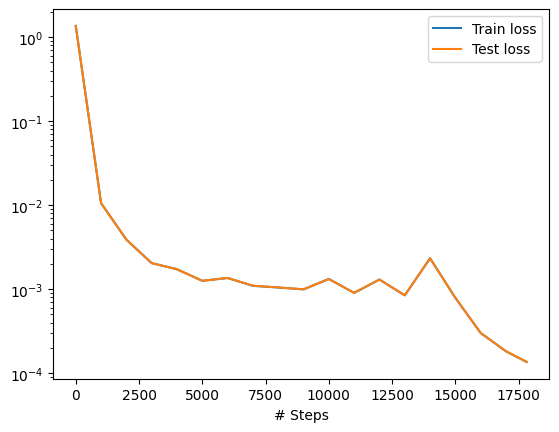

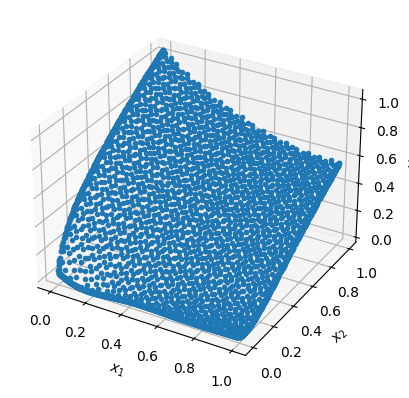

(0.0, 1.0)

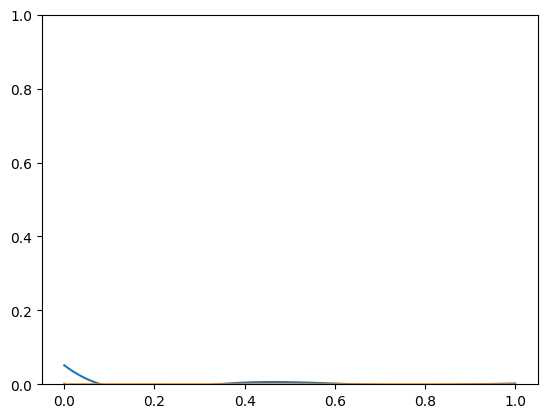

In [18]:
# Визуализация
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
u = []
u_exact = []
t_check = torch.Tensor([0.0])
for x in np.linspace(0,L,1000):
    u.append(model.predict(torch.Tensor([x,t_check])))
    u_exact.append(solution(torch.Tensor([x]),t_check,L,100))
plt.plot(np.linspace(0,L,1000), u)
plt.plot(np.linspace(0,L,1000), u_exact)
plt.ylim(0,1)